# Identifying Vehicles

This is dataset I created after the lesson1 with 10 different types of vehicles. Let's see how we can train a model for that.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
dataset_url = "https://github.com/arunoda/fastai-courses/releases/download/fastai-vehicles-dataset/fastai-vehicles.tgz"

## Loading Data

Currently it's not possible to load data using `untar_data` for data stored in GitHub.<br/>
So, I've to come up with the following utility function to support that.

In [4]:
import os
import subprocess

def exec(commands, cwd=None, show_output=False):
  FNULL = open(os.devnull, 'w')
  if show_output == True:
    cp = subprocess.run(commands, cwd=cwd, universal_newlines=True)
  else:
    cp = subprocess.run(commands, cwd=cwd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
  
  if cp.returncode != 0:
    raise Exception(cp.stdout)

def get_data(name, url):
  homedir = os.getenv('HOME')
  datadir = f'{homedir}/userdata'
  tmpdir = f'/tmp/{name}'
  tarfile = f'{tmpdir}/data.tgz'
  finaldir = f'{datadir}/{name}'

  if os.path.exists(finaldir):
    return Path(finaldir)

  exec(['rm', '-rf', tmpdir])
  exec(['mkdir', '-p', tmpdir])
  exec(['curl', '-L', url, '--output', tarfile], show_output=True)
  exec(['tar', 'xzf', tarfile], cwd=tmpdir)
  exec(['rm', tarfile])

  exec(['rm', '-rf', datadir])
  exec(['mkdir', '-p', datadir])
  exec(['mv', tmpdir, datadir])
  
  return Path(finaldir)

In [5]:
path = get_data("fastai-vehicles", dataset_url); path

PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles')

In [6]:
path.ls()

['images']

In [7]:
path_img = path/'images'
fnames = get_image_files(path_img)
len(fnames)

1204

In [8]:
fnames[:5]

[PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles/images/ suzuki-wagonr-60.jpg'),
 PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles/images/ suzuki-wagonr-97.jpg'),
 PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles/images/audi-q2-67.jpg'),
 PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles/images/audi-a3-64.jpg'),
 PosixPath('/home/arunoda_susiripala/userdata/fastai-vehicles/images/ suzuki-wagonr-40.jpg')]

Okay. Now we've some idea of our dataset. Let's try to create a DataBunch from these images.

In [9]:
pattern = r' *([^/]+)-\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pattern, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

In [10]:
print(len(data.classes))
data.classes

10


['suzuki-wagonr',
 'audi-q2',
 'audi-a3',
 'honda-crv',
 'rangerover',
 'suzuki-swift',
 'defender',
 'honda-civic',
 'jeep-wrangler',
 'honda-fit']

Let's see some random images from our dataset.

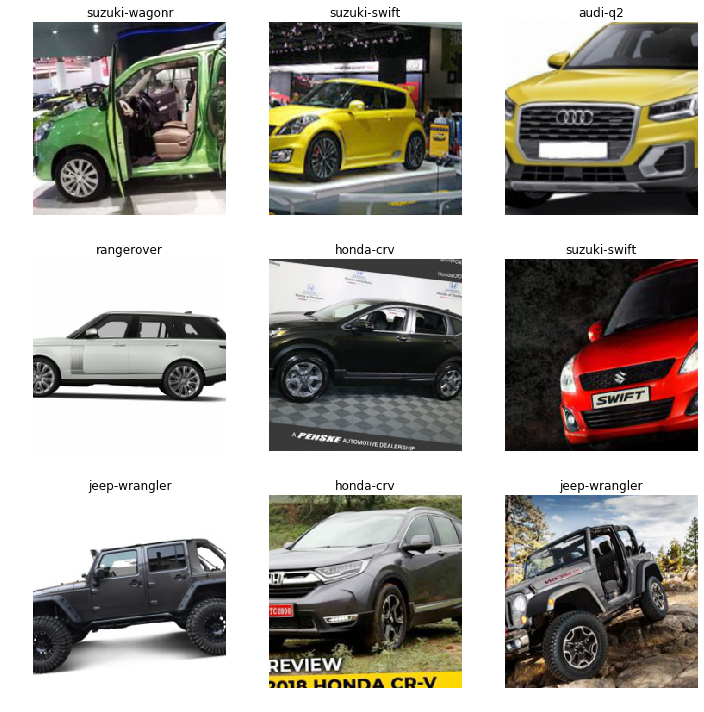

In [11]:
data.show_batch(3, (10, 10))

## Training: resnet34

Let's try to train a model with these data.

In [12]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

Total time: 00:19
epoch  train_loss  valid_loss  error_rate
1      2.313518    1.191572    0.365314    (00:05)
2      1.622887    0.747509    0.258303    (00:04)
3      1.206980    0.590700    0.206642    (00:04)
4      0.966990    0.565790    0.184502    (00:04)



In [13]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


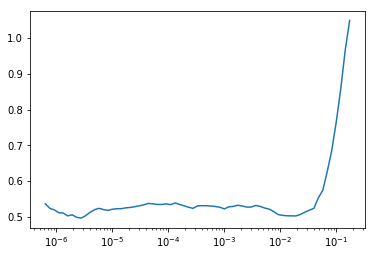

In [14]:
learn.recorder.plot()

In [15]:
learn.unfreeze()

In [16]:
learn.fit_one_cycle(2, slice(1e-6, 1e-3))

Total time: 00:11
epoch  train_loss  valid_loss  error_rate
1      0.529946    0.496194    0.158672    (00:05)
2      0.458855    0.474332    0.147601    (00:05)



## Inspect Result

Here we have an error rate of 15%. Which is bit higher. (But not bad). <br/>
Let's see what has happened to our model.

In [17]:
interpret = ClassificationInterpretation.from_learner(learn)

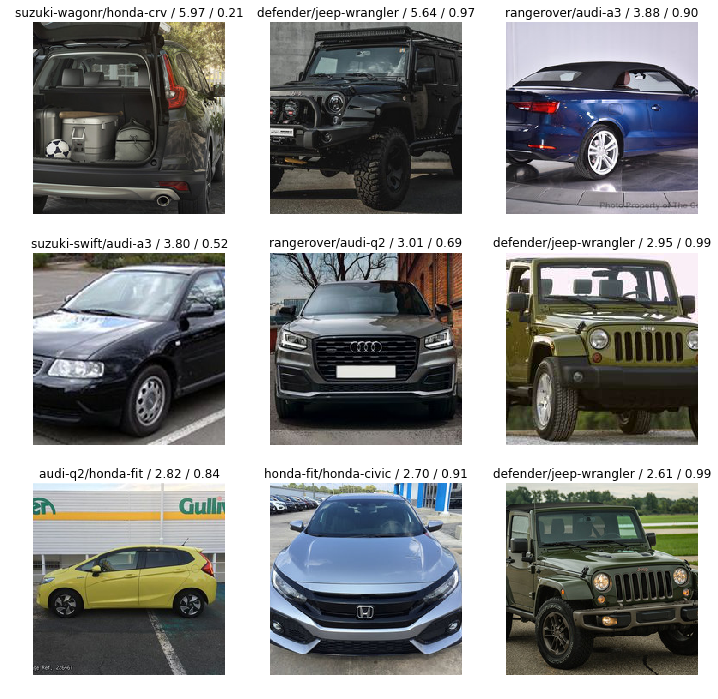

In [18]:
interpret.plot_top_losses(9)

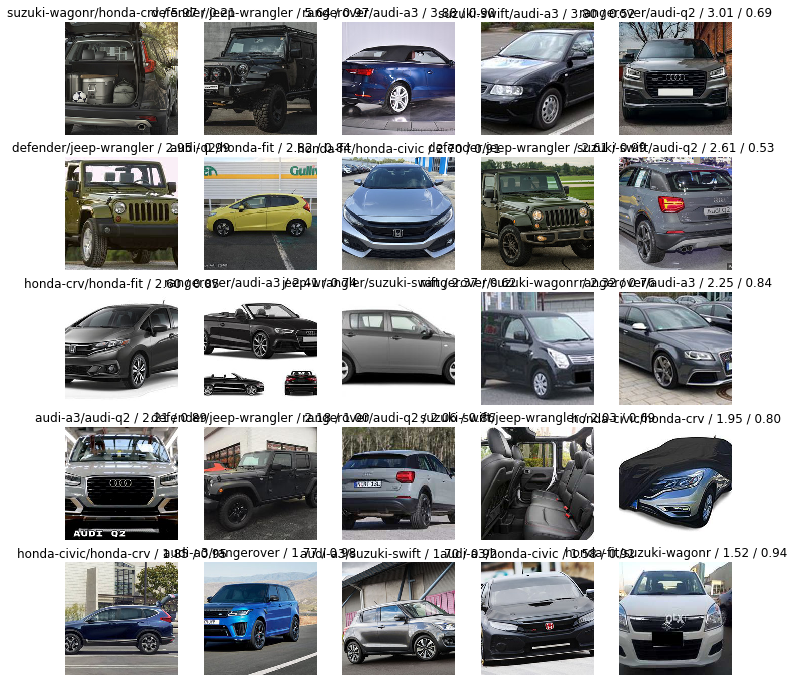

In [19]:
interpret.plot_top_losses(25)

Based on above images, it seems like we can may be improve our images.<br/>
Some of them are quiet fine.<br/>
Let's have a look at the confusion metrics.

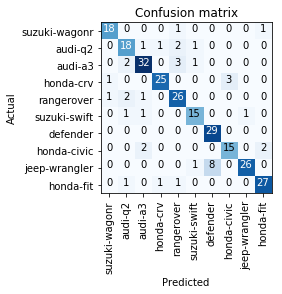

In [20]:
interpret.plot_confusion_matrix()

In [21]:
interpret.most_confused(1)

[('jeep-wrangler', 'defender', 8),
 ('audi-a3', 'rangerover', 3),
 ('honda-crv', 'honda-civic', 3),
 ('audi-q2', 'rangerover', 2),
 ('audi-a3', 'audi-q2', 2),
 ('rangerover', 'audi-q2', 2),
 ('honda-civic', 'audi-a3', 2),
 ('honda-civic', 'honda-fit', 2)]

## Optimization Idea 1: Use resnet50

In [22]:
opt1 = ConvLearner(data, models.resnet50, metrics=error_rate)
opt1.fit_one_cycle(4)

Total time: 00:29
epoch  train_loss  valid_loss  error_rate
1      1.732528    1.002509    0.380074    (00:10)
2      1.117761    0.537877    0.202952    (00:06)
3      0.806171    0.517513    0.188192    (00:06)
4      0.623550    0.468545    0.154982    (00:06)



In [23]:
opt1.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


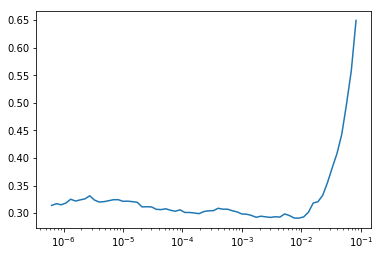

In [24]:
opt1.recorder.plot()

In [25]:
opt1.unfreeze()
opt1.fit_one_cycle(2, slice(1e-6, 1e-3))

Total time: 00:16
epoch  train_loss  valid_loss  error_rate
1      0.303468    0.401883    0.136531    (00:08)
2      0.257011    0.376685    0.125461    (00:07)



**Notes**

The improvement we got here is not that good or worst. <br/>
(It's getting changed slighly as we run out dataset)<br/>
So, I think we can do a lot with our dataset.

## Optimization Idea2: Use square images 

Here we are using square images directly from the source.<br/>
So, when we do a center crop, we don't lose the details of the image.<br/>
Let's see how this model work.

In [26]:
dataset_url_sq = 'https://github.com/arunoda/fastai-courses/releases/download/fastai-vehicles-dataset/fastai-vehicles-square.tgz'
path_sq = get_data('fastai-vehicles-square', dataset_url_sq) 

In [27]:
path_img_sq = path_sq/'images'
fnames_sq = get_image_files(path_img_sq)

In [28]:
pattern = r' *([^/]+)-\d+.jpg$'
data_sq = ImageDataBunch.from_name_re(path_img_sq, fnames_sq, pattern, size=224)
data_sq.normalize(imagenet_stats)

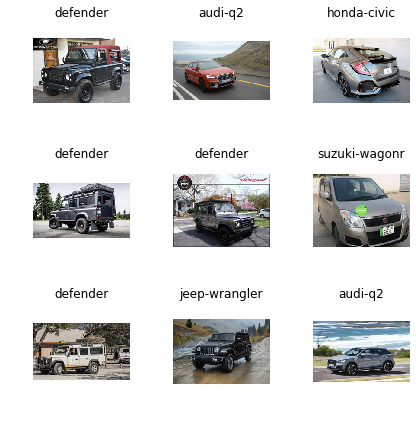

In [29]:
data_sq.show_batch(3, (6, 6))

In [30]:
opt2 = ConvLearner(data_sq, models.resnet34, metrics=error_rate)
opt2.fit_one_cycle(4)

Total time: 00:13
epoch  train_loss  valid_loss  error_rate
1      2.270129    1.344385    0.479339    (00:03)
2      1.518105    0.887978    0.314050    (00:03)
3      1.074577    0.773647    0.280992    (00:03)
4      0.799094    0.766135    0.272727    (00:03)



In [31]:
opt2.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


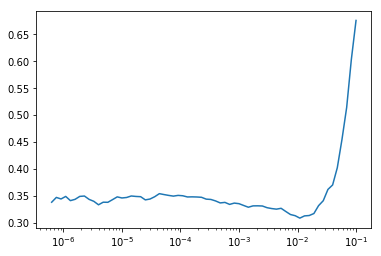

In [32]:
opt2.recorder.plot()

In [33]:
opt2.unfreeze()
opt2.fit_one_cycle(2, slice(1e-6, 1e-3))

Total time: 00:08
epoch  train_loss  valid_loss  error_rate
1      0.345105    0.691635    0.256198    (00:04)
2      0.246538    0.671421    0.219008    (00:03)



In [34]:
inspect_sq = ClassificationInterpretation.from_learner(opt2)

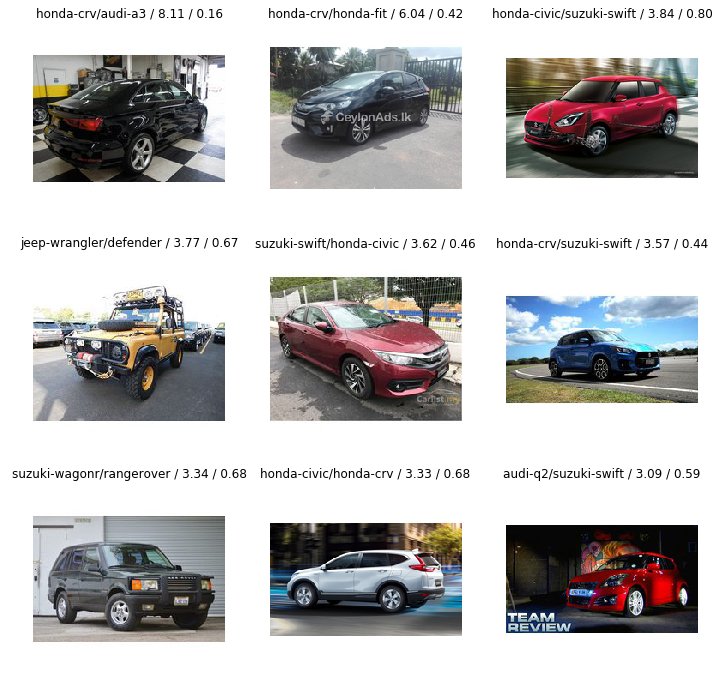

In [35]:
inspect_sq.plot_top_losses(9)

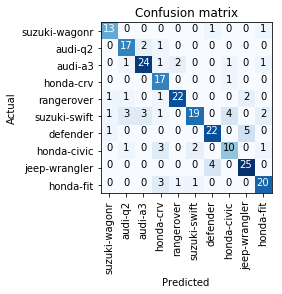

In [36]:
inspect_sq.plot_confusion_matrix()

In [37]:
inspect_sq.most_confused(1)

[('defender', 'jeep-wrangler', 5),
 ('suzuki-swift', 'honda-civic', 4),
 ('jeep-wrangler', 'defender', 4),
 ('suzuki-swift', 'audi-q2', 3),
 ('suzuki-swift', 'audi-a3', 3),
 ('honda-civic', 'honda-crv', 3),
 ('honda-fit', 'honda-crv', 3),
 ('audi-q2', 'audi-a3', 2),
 ('audi-a3', 'rangerover', 2),
 ('rangerover', 'jeep-wrangler', 2),
 ('suzuki-swift', 'honda-fit', 2),
 ('honda-civic', 'suzuki-swift', 2)]

## Optimization Idea 3: square with resnet50

Here we are trying to use the above square images dataset with the restnet50.

In [47]:
opt3 = ConvLearner(data_sq, models.resnet50, metrics=error_rate)
opt3.fit_one_cycle(4, 1e-3)

Total time: 00:20
epoch  train_loss  valid_loss  error_rate
1      2.188702    1.266402    0.400826    (00:04)
2      1.397946    0.732232    0.231405    (00:05)
3      0.964316    0.613674    0.177686    (00:05)
4      0.702185    0.616546    0.177686    (00:04)



LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


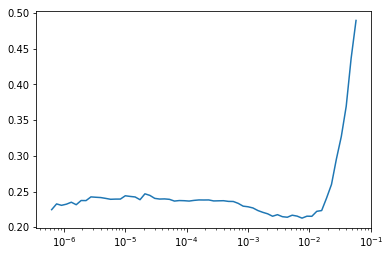

In [48]:
opt3.lr_find()
opt3.recorder.plot()

In [49]:
opt3.unfreeze()
opt3.fit_one_cycle(2, slice(1e-4, 1e-3))

Total time: 00:12
epoch  train_loss  valid_loss  error_rate
1      0.385467    0.709233    0.235537    (00:06)
2      0.277205    0.420500    0.132231    (00:06)

